
# Week 3 — Deep Learning, Backpropagation & Learning (Theory + Practice)

This notebook对应本周的 **理论 + 代码实践**，内容结构：

1. 感知机回顾：从线性可分到几何/模板视角  
2. 多层感知机（MLP）与激活函数  
3. 损失函数与前向传播（Forward Pass）  
4. 反向传播（Backpropagation）与链式法则  
5. 梯度下降、学习率、GD vs SGD vs Mini-batch  
6. 使用 PyTorch 实现 MLP 分类器（从零搭建训练循环）  
7. 正则化：L2 / Weight Decay、Dropout、Early Stopping  
8. Train / Val / Test 划分与超参数调优思路

> 运行前请确认：环境中已安装 `torch`, `torchvision`, `matplotlib`, `numpy`。


In [1]:

import math
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')


## 1. 感知机回顾：线性可分与几何视角

**单个感知机（Perceptron）**：

- 输入：向量 $$x \in \mathbb{R}^d$$
- 参数：权重 $$w \in \mathbb{R}^d$$，偏置 $$b \in \mathbb{R}$$
- 线性打分：$$z = w^\top x + b$$
- 激活：
  - 硬阈值：$$y = \mathbb{I}[z > 0]$$
  - 或连续版本：使用 Sigmoid / Tanh / ReLU 等

从几何上看：
- 超平面 $$w^\top x + b = 0$$ 把空间分成两半。
- 感知机就是在这个超平面一侧输出 1，另一侧输出 0。

**线性可分（linearly separable）**：
- 存在一组 $$w, b$$ 使得所有正样本在一侧，负样本在另一侧。
- 单层感知机只能解决线性可分问题，无法解决 XOR 等非线性可分问题。


In [2]:

# 简单感知机算法（使用 PyTorch tensor 但不依赖 autograd）
torch.manual_seed(0)

# 构造一个二维线性可分数据集
N = 100
X_pos = torch.randn(N, 2)*0.5 + torch.tensor([2.0, 2.0])
X_neg = torch.randn(N, 2)*0.5 + torch.tensor([-2.0, -2.0])
X = torch.cat([X_pos, X_neg], dim=0)
y = torch.cat([torch.ones(N), torch.zeros(N)])  # 1 for positive, 0 for negative

# 初始化参数
w = torch.zeros(2)
b = torch.zeros(1)
lr = 0.1
epochs = 10

def perceptron_predict(x):
    z = x @ w + b
    return (z > 0).float()

for epoch in range(epochs):
    total_errors = 0
    for i in range(X.shape[0]):
        xi = X[i]
        yi = y[i]
        y_pred = perceptron_predict(xi)
        # 感知机更新规则：如果预测错误就更新
        if y_pred != yi:
            update = lr * (yi - y_pred)
            w += update * xi
            b += update
            total_errors += 1
    print(f"Epoch {epoch+1}: errors = {total_errors}")

print("Learned w:", w)
print("Learned b:", b)


Epoch 1: errors = 1
Epoch 2: errors = 0
Epoch 3: errors = 0
Epoch 4: errors = 0
Epoch 5: errors = 0
Epoch 6: errors = 0
Epoch 7: errors = 0
Epoch 8: errors = 0
Epoch 9: errors = 0
Epoch 10: errors = 0
Learned w: tensor([0.1437, 0.1424])
Learned b: tensor([0.1000])


看你的代码，感知机算法没有收敛可能有几个原因：

## 1. 数据可能不是线性可分的

虽然你构造的数据理论上是线性可分的（两个高斯分布中心分别在 (2,2) 和 (-2,-2)），但由于随机噪声，可能存在一些点落在了"错误"的区域。

## 2. 学习率可能不合适

你的学习率是 0.1，可能偏大或偏小。

## 3. 初始化问题

权重初始化为零向量可能导致收敛缓慢。

让我给你一个改进版本：



In [3]:
# 改进的感知机算法
torch.manual_seed(0)

# 构造更明显线性可分的数据集
N = 100
X_pos = torch.randn(N, 2) * 0.5 + torch.tensor([3.0, 3.0])  # 减小方差，增大间距
X_neg = torch.randn(N, 2) * 0.5 + torch.tensor([-3.0, -3.0])
X = torch.cat([X_pos, X_neg], dim=0)
y = torch.cat([torch.ones(N), torch.zeros(N)])

# 改进初始化和学习率
w = torch.randn(2) * 0.01  # 小的随机初始化
b = torch.zeros(1)
lr = 0.01  # 较小的学习率
epochs = 50  # 增加训练轮数

def perceptron_predict(x):
    z = x @ w + b
    return (z > 0).float()

# 添加收敛检查
prev_errors = float('inf')
patience = 5
no_improve_count = 0

for epoch in range(epochs):
    total_errors = 0
    # 随机打乱数据顺序
    indices = torch.randperm(X.shape[0])
    
    for i in indices:
        xi = X[i]
        yi = y[i]
        y_pred = perceptron_predict(xi)
        
        if y_pred != yi:
            update = lr * (yi - y_pred)
            w += update * xi
            b += update
            total_errors += 1
    
    print(f"Epoch {epoch+1}: errors = {total_errors}")
    
    # 早停机制
    if total_errors == 0:
        print("Converged!")
        break
    elif total_errors >= prev_errors:
        no_improve_count += 1
        if no_improve_count >= patience:
            print("No improvement, stopping early")
            break
    else:
        no_improve_count = 0
    
    prev_errors = total_errors

print("Final w:", w)
print("Final b:", b)

Epoch 1: errors = 1
Epoch 2: errors = 0
Converged!
Final w: tensor([0.0217, 0.0339])
Final b: tensor([-0.0100])




## 关键改进：

1. **数据分离度更大**：增大了两类数据的中心距离，减小了方差
2. **更好的初始化**：用小的随机值初始化权重而不是零
3. **调整学习率**：使用更小的学习率 0.01
4. **随机化训练顺序**：每个epoch随机打乱样本顺序
5. **早停机制**：如果连续几轮没有改进就停止
6. **收敛检查**：错误数为0时自动停止

## 如果还是不收敛，可以尝试：



In [4]:
# 检查数据的线性可分性
def check_separability(X, y):
    from sklearn.svm import SVC
    svm = SVC(kernel='linear')
    svm.fit(X.numpy(), y.numpy())
    accuracy = svm.score(X.numpy(), y.numpy())
    print(f"Linear SVM accuracy: {accuracy:.4f}")
    return accuracy == 1.0

is_separable = check_separability(X, y)
print(f"Data is linearly separable: {is_separable}")

Linear SVM accuracy: 1.0000
Data is linearly separable: True




这样可以验证你的数据是否真的线性可分。

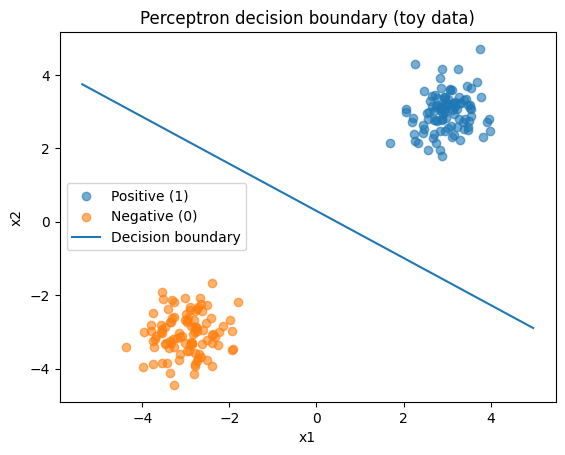

In [5]:

# 可视化决策边界
plt.figure()
plt.scatter(X_pos[:, 0], X_pos[:, 1], label="Positive (1)", alpha=0.6)
plt.scatter(X_neg[:, 0], X_neg[:, 1], label="Negative (0)", alpha=0.6)

# 决策边界 w^T x + b = 0 -> x2 = -(w1/w2) x1 - b/w2
if w[1].abs() > 1e-6:
    x1_vals = torch.linspace(X[:,0].min()-1, X[:,0].max()+1, 100)
    x2_vals = -(w[0]/w[1]) * x1_vals - b[0]/w[1]
    plt.plot(x1_vals, x2_vals, label="Decision boundary")
plt.legend()
plt.title("Perceptron decision boundary (toy data)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()



## 2. 多层感知机（MLP）与激活函数

### 2.1 多层感知机结构

- 输入层：接受原始特征 $$x \in \mathbb{R}^d$$
- 一个或多个隐藏层：
  - 线性变换 $$z^{(1)} = W^{(1)} x + b^{(1)}$$
  - 非线性激活 $$h^{(1)} = g(z^{(1)})$$
  - 继续堆叠 $$z^{(2)} = W^{(2)} h^{(1)} + b^{(2)}$$, ...
- 输出层：通常是线性层 + Softmax（分类）或线性回归头（回归）。

如果所有层都是线性的：
$$
f(x) = W^{(L)} W^{(L-1)} \cdots W^{(1)} x + \tilde b
$$
仍然只是一个线性变换 ⇒ **必须有非线性激活函数** 才能表达复杂函数。

### 2.2 常见激活函数

- Sigmoid:
  $$
  \sigma(z) = \frac{1}{1 + e^{-z}},\quad \sigma'(z) = \sigma(z)(1-\sigma(z))
  $$
- Tanh:
  $$
  \tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}},\quad \tanh'(z) = 1 - \tanh^2(z)
  $$
- ReLU:
  $$
  \mathrm{ReLU}(z) = \max(0, z)
  $$

在深度网络中，ReLU 由于**稀疏激活 + 梯度传播好**，非常常见。


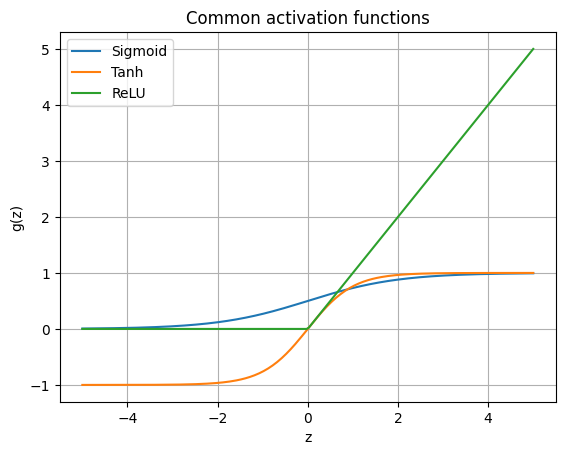

In [6]:

# 画几个常见激活函数
z = torch.linspace(-5, 5, 200)
sigmoid = torch.sigmoid(z)
tanh = torch.tanh(z)
relu = torch.relu(z)

plt.figure()
plt.plot(z.numpy(), sigmoid.numpy(), label="Sigmoid")
plt.plot(z.numpy(), tanh.numpy(), label="Tanh")
plt.plot(z.numpy(), relu.numpy(), label="ReLU")
plt.legend()
plt.title("Common activation functions")
plt.xlabel("z"); plt.ylabel("g(z)")
plt.grid(True)
plt.show()



## 3. 损失函数与前向传播（Forward Pass）

设网络参数为 $\theta$，给定样本 $(x_i, y_i)$，模型预测为 $\hat y_i = f(x_i; \theta)$。

**分类任务常用的损失：交叉熵（Cross-Entropy）**。

假设我们用线性层 + Softmax 得到对每个类别 $(k)$ 的概率：
$$
p_k = \frac{e^{s_k}}{\sum_j e^{s_j}}, \quad s = Wx + b
$$

- 对于 one-hot 真实标签 $(y)$，交叉熵损失：
$$
\mathcal{L}_i = - \sum_k y_{ik} \log p_k = -\log p_{y_i}
$$

整个数据集的目标：
$$
J(\theta) = \frac{1}{n} \sum_{i=1}^n \mathcal{L}_i
$$

下面我们用一个简单的两层 MLP 做前向传播和损失计算的示例。


In [7]:

# 一个简单的两层 MLP 前向传播示例（不训练，只看维度）
batch_size = 4
input_dim = 10
hidden_dim = 5
num_classes = 3

torch.manual_seed(0)
X_demo = torch.randn(batch_size, input_dim)
y_demo = torch.randint(0, num_classes, (batch_size,))

mlp = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, num_classes)
)

logits = mlp(X_demo)              # (batch_size, num_classes)
loss_fn = nn.CrossEntropyLoss()
loss_val = loss_fn(logits, y_demo)

print("logits shape:", logits.shape)
print("y_demo:", y_demo)
print("loss:", loss_val.item())


logits shape: torch.Size([4, 3])
y_demo: tensor([2, 1, 2, 2])
loss: 1.383055567741394



## 4. 反向传播（Backpropagation）与链式法则

以一个简单的两层网络为例：

- 输入 $x$
- 隐藏层：$z^{(1)} = W^{(1)} x + b^{(1)}$, $h^{(1)} = g(z^{(1)})$
- 输出层：$z^{(2)} = W^{(2)} h^{(1)} + b^{(2)}$, 输出 $\hat y = f(z^{(2)})$
- 损失：$\mathcal{L}(\hat y, y)$

我们想要 $\frac{\partial \mathcal{L}}{\partial W^{(1)}}$、$\frac{\partial \mathcal{L}}{\partial W^{(2)}}$。

利用链式法则：

1. 先从输出层开始：
   $$
   \delta^{(2)} = \frac{\partial \mathcal{L}}{\partial z^{(2)}}
   $$
2. 对输出层参数：
   $$
   \frac{\partial \mathcal{L}}{\partial W^{(2)}} = \delta^{(2)} (h^{(1)})^\top,
   \quad
   \frac{\partial \mathcal{L}}{\partial b^{(2)}} = \delta^{(2)}
   $$
3. 传回隐藏层：
   $$
   \delta^{(1)} = (W^{(2)})^\top \delta^{(2)} \odot g'(z^{(1)})
   $$
4. 对隐藏层参数：
   $$
   \frac{\partial \mathcal{L}}{\partial W^{(1)}} = \delta^{(1)} x^\top,
   \quad
   \frac{\partial \mathcal{L}}{\partial b^{(1)}} = \delta^{(1)}
   $$
   

**反向传播算法**本质上就是：
- 按计算图，从后往前应用链式法则，
- 复用中间结果（\(\delta\)），避免重复计算，
- 最终得到所有参数的梯度。


In [8]:

# 手动实现一个极简两层网络的反向传播，并与 autograd 对比

torch.manual_seed(0)

# 单样本示例
x = torch.randn(3, 1)              # input dim = 3, shape (3,1)
y_true = torch.tensor([[1.0]])     # regression scalar target

# 参数初始化
W1 = torch.randn(4, 3, requires_grad=True)  # hidden dim = 4
b1 = torch.randn(4, 1, requires_grad=True)
W2 = torch.randn(1, 4, requires_grad=True)
b2 = torch.randn(1, 1, requires_grad=True)

def forward_manual(x, W1, b1, W2, b2):
    z1 = W1 @ x + b1
    h1 = torch.tanh(z1)
    z2 = W2 @ h1 + b2
    y_pred = z2
    return y_pred, (z1, h1, z2)

# 用 autograd 计算梯度
y_pred, (z1, h1, z2) = forward_manual(x, W1, b1, W2, b2)
loss = 0.5 * (y_pred - y_true).pow(2).sum()
loss.backward()

grads_auto = {
    "dW1": W1.grad.clone(),
    "db1": b1.grad.clone(),
    "dW2": W2.grad.clone(),
    "db2": b2.grad.clone()
}

# 手动反向传播（不依赖 autograd）
# 为了对比，重新创建不带 grad 的参数
W1_ = W1.detach().clone()
b1_ = b1.detach().clone()
W2_ = W2.detach().clone()
b2_ = b2.detach().clone()

def backward_manual(x, y_true, W1, b1, W2, b2):
    # forward
    z1 = W1 @ x + b1
    h1 = torch.tanh(z1)
    z2 = W2 @ h1 + b2
    y_pred = z2
    loss = 0.5 * (y_pred - y_true).pow(2).sum()

    # backward
    dL_dy = (y_pred - y_true)          # dL/dy_pred
    dL_dz2 = dL_dy                     # z2 = y_pred

    dL_dW2 = dL_dz2 @ h1.t()
    dL_db2 = dL_dz2

    dL_dh1 = W2.t() @ dL_dz2
    dL_dz1 = dL_dh1 * (1 - torch.tanh(z1)**2)   # tanh'(z) = 1 - tanh(z)^2

    dL_dW1 = dL_dz1 @ x.t()
    dL_db1 = dL_dz1

    return loss.item(), dL_dW1, dL_db1, dL_dW2, dL_db2

loss_manual, dW1_m, db1_m, dW2_m, db2_m = backward_manual(x, y_true, W1_, b1_, W2_, b2_)

print("Loss auto:   ", loss.item())
print("Loss manual: ", loss_manual)
print()
print("||dW1_auto - dW1_manual||:", (grads_auto["dW1"] - dW1_m).norm().item())
print("||db1_auto - db1_manual||:", (grads_auto["db1"] - db1_m).norm().item())
print("||dW2_auto - dW2_manual||:", (grads_auto["dW2"] - dW2_m).norm().item())
print("||db2_auto - db2_manual||:", (grads_auto["db2"] - db2_m).norm().item())


Loss auto:    2.492147445678711
Loss manual:  2.492147445678711

||dW1_auto - dW1_manual||: 5.631364956570906e-07
||db1_auto - db1_manual||: 2.4374332951992983e-07
||dW2_auto - dW2_manual||: 0.0
||db2_auto - db2_manual||: 0.0



## 5. 梯度下降、学习率、GD vs SGD vs Mini-batch

我们希望通过迭代更新参数来最小化损失函数 $J(\theta)$：

$$
\theta \leftarrow \theta - \eta \nabla_\theta J(\theta)
$$

- eta：学习率（step size），太小收敛慢，太大可能发散。
- **Batch GD**：每次用全训练集计算梯度。
- **Stochastic GD (SGD)**：每次只用 1 个样本计算梯度。
- **Mini-batch SGD**：每次用一个小批量（例如 32 个样本），在深度学习中最常用。

下面用一个简单的 1D 函数演示**学习率过大/过小**的情况。


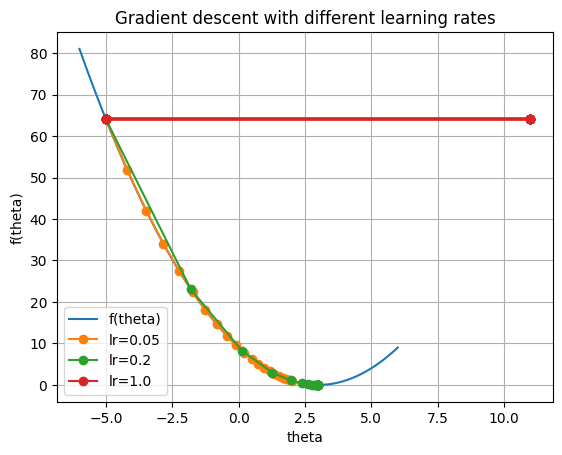

In [9]:

# 梯度下降演示：f(theta) = (theta-3)^2
def f(theta):
    return (theta - 3.0)**2

def df(theta):
    return 2*(theta - 3.0)

def run_gd(lr, steps=20):
    theta = -5.0
    traj = [theta]
    for _ in range(steps):
        theta = theta - lr * df(theta)
        traj.append(theta)
    return traj

lrs = [0.05, 0.2, 1.0]
thetas_list = [run_gd(lr) for lr in lrs]

plt.figure()
xs = torch.linspace(-6, 6, 200)
plt.plot(xs.numpy(), f(xs).numpy(), label="f(theta)")

for lr, traj in zip(lrs, thetas_list):
    plt.plot(traj, [f(t) for t in traj], marker="o", label=f"lr={lr}")

plt.legend()
plt.title("Gradient descent with different learning rates")
plt.xlabel("theta")
plt.ylabel("f(theta)")
plt.grid(True)
plt.show()



## 6. 使用 PyTorch 训练 MLP（以 MNIST 为例）

这里我们：

1. 使用 `torchvision.datasets.MNIST` 加载手写数字数据集（如有网络问题可以改为本地数据）。  
2. 定义一个简单的 MLP：输入层 → 隐藏层 + ReLU → 输出层。  
3. 使用交叉熵损失和 mini-batch SGD 训练。  
4. 观察训练/验证集上的准确率。

> 如果你在服务器上不能下载 MNIST，可以把这段换成你自己的 `TensorDataset`。


In [10]:

# 下载/加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # 标准 MNIST 均值方差
])

train_dataset_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

len(train_dataset_full), len(test_dataset)


(60000, 10000)

In [11]:

# 划分 train / val
val_ratio = 0.1
val_size = int(len(train_dataset_full) * val_ratio)
train_size = len(train_dataset_full) - val_size

train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_size, val_size


(54000, 6000)

In [12]:

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=256, num_classes=10, dropout_p=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            total_acc += accuracy(logits, y) * batch_size
            total_samples += batch_size
    return total_loss / total_samples, total_acc / total_samples


In [13]:

# 训练循环（mini-batch SGD）
def train_mlp(dropout_p=0.0, weight_decay=0.0, lr=1e-2, epochs=5):
    model = MLPClassifier(dropout_p=dropout_p).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses, val_accs = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = x.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

        train_loss = running_loss / total_samples
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    return model, (train_losses, val_losses, val_accs)


In [14]:

# 训练一个基础 MLP（无正则化）
model_base, stats_base = train_mlp(dropout_p=0.0, weight_decay=0.0, lr=0.1, epochs=5)


Epoch 1/5: train_loss=0.3400, val_loss=0.2061, val_acc=94.22%
Epoch 2/5: train_loss=0.1590, val_loss=0.1494, val_acc=95.87%
Epoch 3/5: train_loss=0.1117, val_loss=0.1196, val_acc=96.55%
Epoch 4/5: train_loss=0.0864, val_loss=0.1074, val_acc=96.92%
Epoch 5/5: train_loss=0.0706, val_loss=0.0970, val_acc=97.08%


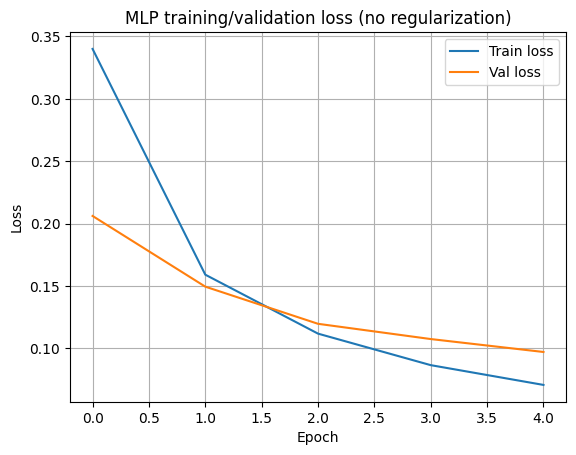

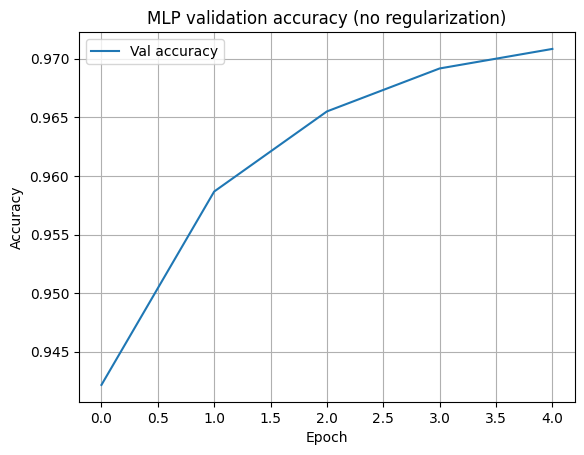

In [15]:

train_losses, val_losses, val_accs = stats_base

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP training/validation loss (no regularization)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_accs, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP validation accuracy (no regularization)")
plt.legend()
plt.grid(True)
plt.show()



## 7. 正则化：Weight Decay（L2）、Dropout、Early Stopping

### 7.1 Weight Decay / L2 正则化

在损失函数中加入参数范数惩罚项：

$$
J_{\text{reg}}(\theta) = J(\theta) + \lambda \|\theta\|_2^2
$$

在 PyTorch 中，可以通过优化器的 `weight_decay` 参数自动实现 L2 正则。

### 7.2 Dropout

训练时，以概率 \(p\) 随机“丢弃”（置零）一部分神经元：
- 迫使网络不能过度依赖某个特征。  
- 等价于在训练时随机采样很多子网络，测试时使用一个“平均网络”。

在 PyTorch 中，只需在网络中加入 `nn.Dropout(p)` 层即可。

### 7.3 Early Stopping

当验证集损失在若干轮内不再下降时停止训练：
- 防止继续拟合训练集噪声。  
- 实现方式：训练过程中记录最佳验证损失及对应参数，如果连续 K 个 epoch 未提升则停止并回滚到最佳参数。


In [16]:

# 对比：使用 Dropout + Weight Decay 的 MLP
model_reg, stats_reg = train_mlp(dropout_p=0.5, weight_decay=1e-4, lr=0.1, epochs=5)


Epoch 1/5: train_loss=0.4069, val_loss=0.2027, val_acc=94.23%
Epoch 2/5: train_loss=0.2125, val_loss=0.1520, val_acc=95.58%
Epoch 3/5: train_loss=0.1707, val_loss=0.1273, val_acc=96.45%
Epoch 4/5: train_loss=0.1428, val_loss=0.1108, val_acc=96.65%
Epoch 5/5: train_loss=0.1286, val_loss=0.0990, val_acc=97.17%


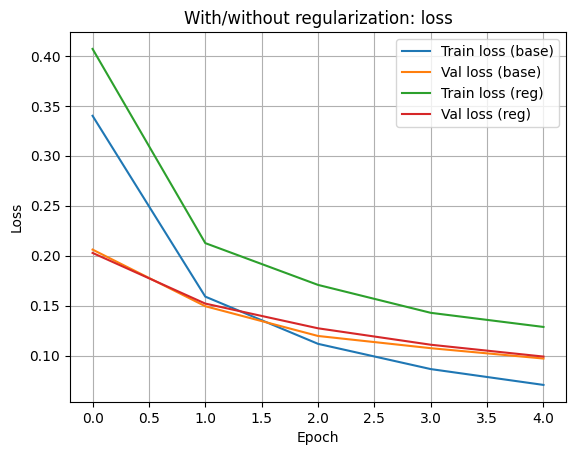

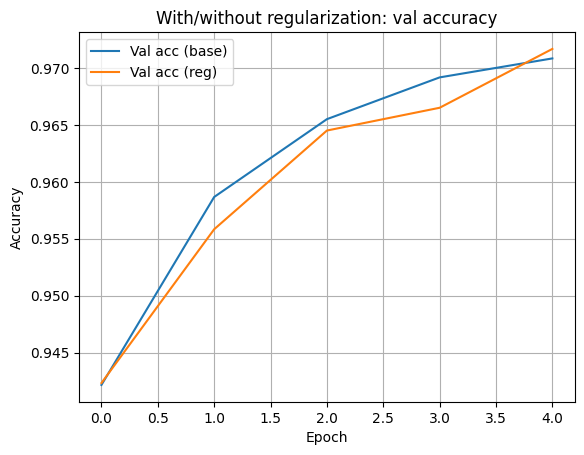

In [17]:

train_losses_reg, val_losses_reg, val_accs_reg = stats_reg

plt.figure()
plt.plot(train_losses, label="Train loss (base)")
plt.plot(val_losses, label="Val loss (base)")
plt.plot(train_losses_reg, label="Train loss (reg)")
plt.plot(val_losses_reg, label="Val loss (reg)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("With/without regularization: loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_accs, label="Val acc (base)")
plt.plot(val_accs_reg, label="Val acc (reg)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("With/without regularization: val accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [18]:

# 在测试集上评估
loss_fn = nn.CrossEntropyLoss()
test_loss_base, test_acc_base = evaluate(model_base, test_loader, loss_fn, device)
test_loss_reg, test_acc_reg = evaluate(model_reg, test_loader, loss_fn, device)

print(f"Base model:   test_loss={test_loss_base:.4f}, test_acc={test_acc_base*100:.2f}%")
print(f"Reg  model:   test_loss={test_loss_reg:.4f}, test_acc={test_acc_reg*100:.2f}%")


Base model:   test_loss=0.0824, test_acc=97.44%
Reg  model:   test_loss=0.0892, test_acc=97.39%



## 8. Train / Val / Test 划分与超参数调优（总结）

- **Train 集**：用于更新参数（通过反向传播和优化器）。  
- **Validation 集**：用于选择超参数（学习率、隐藏层维度、层数、正则化强度、Dropout 概率等），以及执行 Early Stopping。  
- **Test 集**：仅在所有设计选择完成之后，用于报告最终性能，不能参与调参。

**典型深度学习训练流程：**

1. 划分数据集：Train / Val / Test。  
2. 选定一组初始超参数：
   - 学习率 `lr`
   - 批大小 `batch_size`
   - 网络结构（层数、隐藏维度、激活函数等）
   - 正则化（weight_decay、dropout_p）
3. 在训练集上用 mini-batch SGD 训练，监控验证集 loss / acc：
   - 如验证集指标多轮未提升，则触发 Early Stopping。  
4. 用验证集表现最好的模型，在 Test 集上评估并报告结果。  
5. 如有必要，在验证集上做网格搜索 / 随机搜索 / 贝叶斯优化等更多自动化超参数搜索。

---

### 小结

这一份 notebook 将本周的核心内容 **“理论 + 代码实践”** 串起来：

- 从感知机、MLP 和激活函数讲起，理解**深度和非线性的必要性**；  
- 用链式法则推导反向传播，并用 PyTorch 的 autograd 验证；  
- 对比不同学习率下的梯度下降行为，理解 GD / SGD / mini-batch 的差别；  
- 在 MNIST 上完整实现一个 MLP 的训练循环，并加入 **L2 / Dropout 正则化** 和 **train/val/test 划分**。

你可以基于此 notebook：
- 加更多网络结构（多层、BatchNorm 等）做实验；  
- 修改优化器（如 Adam）比较收敛速度；  
- 观察不同正则化强度 / Dropout 概率对过拟合的影响。
